In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
#Data Cleaning
df= pd.read_excel("Song_Dataset.xlsx")
df_song = pd.read_excel("Song_Dataset.xlsx", sheet_name="Song_Deatils")
df_node = pd.read_excel("Song_Dataset.xlsx", sheet_name="Node_Deatils")
df_dict = pd.read_excel("Song_Dataset.xlsx", sheet_name="Data Dictionary")
xls = pd.ExcelFile("Song_Dataset.xlsx")
xls.sheet_names


['Song_Deatils', 'Node_Deatils', 'Data Dictionary']

In [44]:
df_song.head()
df_song.info()
df_song.shape
df_song.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Song_Id               949 non-null    object 
 1   track_name            949 non-null    object 
 2   artist(s)_name        949 non-null    object 
 3   artist_count          949 non-null    int64  
 4   released_year         949 non-null    int64  
 5   released_month        949 non-null    object 
 6   released_day          949 non-null    int64  
 7   in_spotify_playlists  949 non-null    int64  
 8   in_spotify_charts     949 non-null    int64  
 9   streams               949 non-null    object 
 10  in_apple_playlists    949 non-null    int64  
 11  in_apple_charts       949 non-null    int64  
 12  in_deezer_playlists   949 non-null    int64  
 13  in_deezer_charts      949 non-null    int64  
 14  in_shazam_charts      898 non-null    float64
 15  bpm                   9

Song_Id                  0
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        51
bpm                      0
key                     96
mode                     0
dtype: int64

In [45]:
# Song_Deatils song_ID cleaning
df_song['Song_Id_clean'] = (
    df_song['Song_Id']
    .str.replace(',', '', regex=False)
    .astype(int)
)

# Node_Deatils song_ID cleaning
df_node['Song_Id_clean'] = (
    df_node['Song_Id']
    .astype(int)
)

In [46]:
df_song['Song_Id_clean'].nunique()

813

In [47]:
df_node['Song_Id_clean'].nunique()

816

In [48]:
# Counting Song_Ids for repeating values
df_song["song_id_count"] = (
    df_song.groupby("Song_Id_clean")["Song_Id_clean"]
           .transform("count")
)

df_node["song_id_count"] = (
    df_node.groupby("Song_Id_clean")["Song_Id_clean"]
           .transform("count")
)

In [49]:
df_song_clean = df_song[df_song["song_id_count"] == 1]
df_node_clean = df_node[df_node["song_id_count"] == 1]

In [50]:
df_merged = pd.merge(
    df_song_clean,
    df_node_clean,
    on="Song_Id_clean",
    how="inner"
)

In [51]:
df_merged.shape

(676, 29)

In [52]:
#Correcting the release month format
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df_merged['released_month_clean'] = df_merged['released_month']

df_merged['released_month_clean'] = (
    df_merged['released_month_clean']
    .replace(month_map)
    .infer_objects(copy=False)
    .astype(int)
)

df_merged = df_merged[df_merged['released_year'] <= 2025]

#cleaned Streams column
df_merged['streams_clean'] = (
    df_merged['streams']
    .astype(str)
    .str.replace(',', '', regex=False)
)

df_merged['streams_clean'] = pd.to_numeric(
    df_merged['streams_clean'],
    errors='coerce'
)

#Popularity approach based on Avg Streams
CURRENT_YEAR = 2025

df_merged['song_age_years'] = CURRENT_YEAR - df_merged['released_year']

df_merged['song_age_years'] = df_merged['song_age_years'].clip(lower=1)

df_merged['avg_streams_per_year'] = (
    df_merged['streams_clean'] / df_merged['song_age_years']
)

C:\Users\USER\AppData\Local\Temp\ipykernel_16748\2349393951.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(month_map)


In [53]:
df_merged.shape

(674, 33)

In [54]:
df_merged[['streams_clean', 'released_month_clean']].isnull().sum()
df_merged['streams_clean'].fillna(0)

0      141381703.0
1      140003974.0
2      800840817.0
3      303236322.0
4      183706234.0
          ...     
671     91473363.0
672    121871870.0
673     73513683.0
674    133895612.0
675     96007391.0
Name: streams_clean, Length: 674, dtype: float64

In [55]:
#Fiiling Null values in Audio Features
audio_features = [
    'danceability_%',
    'valence_%',
    'energy_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

df_merged[audio_features] = df_merged[audio_features].fillna(0)

#Filling Null values in Shazam Charts
df_merged['in_shazam_charts'] = (
    df_merged['in_shazam_charts']
    .fillna(0)
    .astype(int)
)

In [56]:
df_merged.isnull().sum()

Song_Id_x                0
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts         0
bpm                      0
key                     66
mode                     0
Song_Id_clean            0
song_id_count_x          0
Song_Id_y                0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
song_id_count_y          0
released_month_clean     0
streams_clean            1
song_age_years           0
avg_streams_per_year     1
dtype: int64

In [57]:
#Popularity Column
threshold = df_merged['avg_streams_per_year'].quantile(0.75)
df_merged['high_popularity'] = (
    df_merged['avg_streams_per_year'] >= threshold
).astype(int)

#Sanity Check
df_merged['high_popularity'].value_counts(normalize=True)

#Popularity Label
df_merged['Popularity_Label'] = df_merged['high_popularity'].map({
    1: 'Popular Songs',
    0: 'Other Songs'
})

In [58]:
df_merged[['released_year', 'streams_clean', 'avg_streams_per_year','high_popularity','Popularity_Label']].head(10)

,released_year,streams_clean,avg_streams_per_year,high_popularity,Popularity_Label
0,2023,141381703.0,70690851.5,0,Other Songs
1,2023,140003974.0,70001987.0,0,Other Songs
2,2019,800840817.0,133473469.5,0,Other Songs
3,2025,303236322.0,303236322.0,1,Popular Songs
4,2023,183706234.0,91853117.0,0,Other Songs
5,2023,58149378.0,29074689.0,0,Other Songs
6,2023,335222234.0,167611117.0,1,Popular Songs
7,2023,363369738.0,181684869.0,1,Popular Songs
8,2023,86444842.0,43222421.0,0,Other Songs
9,2023,115364561.0,57682280.5,0,Other Songs


In [59]:
#Creating another sheet by excluding the years with no Popular songs based on avg streams per year
df_analysis = df_merged[
    (df_merged['released_year'] >= 2011) &
    (df_merged['released_year'] <= 2025)
].copy()

In [60]:
with pd.ExcelWriter('Spotify_Song_Analysis_Final.xlsx', engine='openpyxl') as writer:
    df_merged.to_excel(writer, sheet_name='Clean_Raw_Data', index=False)
    df_analysis.to_excel(writer, sheet_name='Analysis_2011_2025', index=False)

In [61]:
df_analysis.head(5)

,Song_Id_x,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,...,instrumentalness_%,liveness_%,speechiness_%,song_id_count_y,released_month_clean,streams_clean,song_age_years,avg_streams_per_year,high_popularity,Popularity_Label
0,"4,137",Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,...,0.0,8.0,4.0,1,7,141381703.0,2,70690851.5,0,Other Songs
1,"3,520",vampire,Olivia Rodrigo,1,2023,June,30,1397,113,140003974,...,0.0,31.0,6.0,1,6,140003974.0,2,70001987.0,0,Other Songs
2,"3,362",Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,...,0.0,11.0,15.0,1,8,800840817.0,6,133473469.5,0,Other Songs
3,"3,914",WHERE SHE GOES,Bad Bunny,1,2025,May,18,3133,50,303236322,...,63.0,11.0,6.0,1,5,303236322.0,1,303236322.0,1,Popular Songs
4,"3,423",Sprinter,"Dave, Central Cee",2,2023,June,1,2186,91,183706234,...,0.0,8.0,24.0,1,6,183706234.0,2,91853117.0,0,Other Songs


In [62]:
#Audio Features and relation to High popularity songs
feature_cols = [
    'danceability_%', 'energy_%', 'valence_%',
    'acousticness_%', 'instrumentalness_%',
    'liveness_%', 'speechiness_%'
]

feature_yoy = (
    df_analysis
    .groupby(['released_year', 'Popularity_Label'])[feature_cols]
    .mean()
    .reset_index()
)

feature_yoy.tail(10)

,released_year,Popularity_Label,danceability_%,energy_%,valence_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
17,2019,Popular Songs,65.357143,51.000000,40.357143,30.142857,0.285714,14.642857,7.428571
18,2020,Other Songs,65.777778,53.888889,45.000000,20.111111,0.000000,11.555556,13.444444
19,2020,Popular Songs,64.454545,63.090909,45.454545,27.045455,0.181818,18.727273,7.954545
20,2021,Other Songs,61.911111,63.333333,54.822222,24.688889,2.000000,13.600000,11.466667
21,2021,Popular Songs,61.794118,58.000000,45.647059,27.705882,0.147059,16.588235,9.764706
22,2022,Other Songs,62.962185,60.105042,47.773109,27.289916,1.705882,17.663866,10.752101
23,2022,Popular Songs,64.767857,59.589286,45.910714,21.857143,0.410714,18.250000,9.750000
24,2023,Other Songs,65.333333,65.431373,49.470588,21.372549,0.647059,19.568627,9.303922
25,2023,Popular Songs,70.125000,68.375000,60.250000,33.750000,0.000000,19.500000,8.250000
26,2025,Popular Songs,65.000000,80.000000,23.000000,14.000000,63.000000,11.000000,6.000000


In [63]:
feature_yoy_long = feature_yoy.melt(
    id_vars=['released_year', 'Popularity_Label'],
    var_name='Audio_Feature',
    value_name='Avg_Feature_Value'
)

feature_yoy_long

,released_year,Popularity_Label,Audio_Feature,Avg_Feature_Value
0,2011,Other Songs,danceability_%,54.000000
1,2011,Popular Songs,danceability_%,63.000000
2,2012,Other Songs,danceability_%,70.500000
3,2012,Popular Songs,danceability_%,16.500000
4,2013,Other Songs,danceability_%,60.000000
...,...,...,...,...
184,2022,Other Songs,speechiness_%,10.752101
185,2022,Popular Songs,speechiness_%,9.750000
186,2023,Other Songs,speechiness_%,9.303922
187,2023,Popular Songs,speechiness_%,8.250000


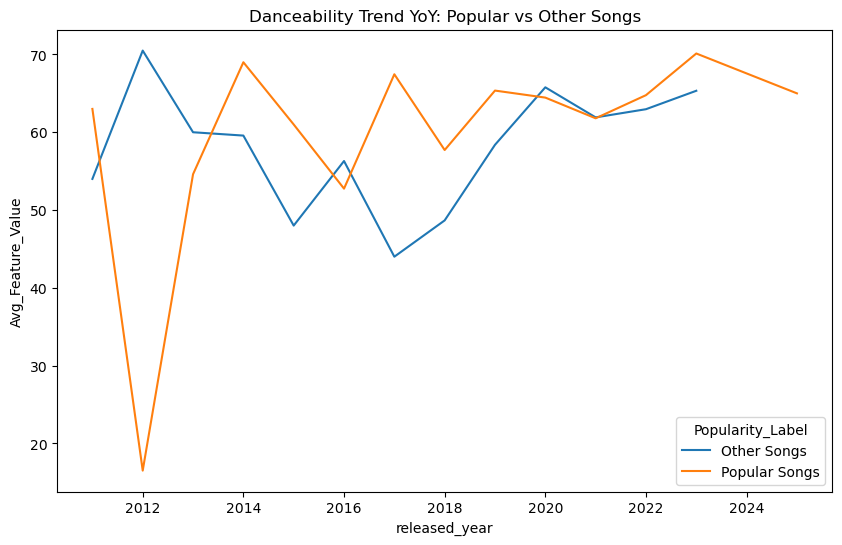

In [64]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=feature_yoy_long[feature_yoy_long['Audio_Feature'] == 'danceability_%'],
    x='released_year',
    y='Avg_Feature_Value',
    hue='Popularity_Label'
)
plt.title('Danceability Trend YoY: Popular vs Other Songs')
plt.show()

In [65]:
#BPM relation with Popularity
bpm_yoy = (
    df_analysis
    .groupby(['released_year', 'Popularity_Label'])['bpm']
    .mean()
    .reset_index()
)

bpm_yoy.head(10)

,released_year,Popularity_Label,bpm
0,2011,Other Songs,132.400000
1,2011,Popular Songs,146.000000
2,2012,Other Songs,145.750000
3,2012,Popular Songs,151.500000
4,2013,Other Songs,120.857143
5,2013,Popular Songs,116.000000
6,2014,Other Songs,104.142857
7,2014,Popular Songs,89.666667
8,2015,Other Songs,123.500000
9,2015,Popular Songs,100.000000


In [66]:
bpm_yoy.pivot(
    index='released_year',
    columns='Popularity_Label',
    values='bpm'
)

Popularity_Label,Other Songs,Popular Songs
released_year,,
2011,132.400000,146.000000
2012,145.750000,151.500000
2013,120.857143,116.000000
2014,104.142857,89.666667
2015,123.500000,100.000000
2016,131.700000,129.750000
2017,112.600000,114.454545
2018,112.666667,116.428571
2019,120.923077,118.071429


In [67]:
#Playlists presence vs popularity
df_analysis['in_spotify_playlists'].describe()

count      621.000000
mean      4555.673108
std       6966.969358
min         34.000000
25%        847.000000
50%       2094.000000
75%       4942.000000
max      52898.000000
Name: in_spotify_playlists, dtype: float64

In [68]:
def spotify_playlist_bucket(x):
    if x == 0:
        return 'None'
    elif x <= 1000:
        return 'Low'
    elif x <= 6000:
        return 'Medium'
    elif x <= 20000:
        return 'High'
    else:
        return 'Very High'

df_analysis['Spotify_Playlist_Bucket'] = (
    df_analysis['in_spotify_playlists']
    .apply(spotify_playlist_bucket)
)

#yoy playlist analysis
playlist_yoy = (
    df_analysis
    .groupby(['released_year', 'Spotify_Playlist_Bucket', 'Popularity_Label'])
    ['avg_streams_per_year']
    .mean()
    .reset_index()
)

playlist_yoy

,released_year,Spotify_Playlist_Bucket,Popularity_Label,avg_streams_per_year
0,2011,High,Other Songs,5.402473e+07
1,2011,High,Popular Songs,1.395381e+08
2,2011,Very High,Other Songs,8.717060e+07
3,2012,High,Other Songs,9.084983e+07
4,2012,High,Popular Songs,1.395134e+08
...,...,...,...,...
57,2023,Low,Other Songs,4.363751e+07
58,2023,Low,Popular Songs,1.998494e+08
59,2023,Medium,Other Songs,7.274424e+07
60,2023,Medium,Popular Songs,2.243076e+08


In [69]:
#Chats as momentum indicators for popularity rise
spotify_charts_yoy = (
    df_analysis
    .groupby(['released_year', 'Popularity_Label'])['in_spotify_charts']
    .mean()
    .reset_index()
)

spotify_charts_yoy.pivot(
    index='released_year',
    columns='Popularity_Label',
    values='in_spotify_charts'
)

Popularity_Label,Other Songs,Popular Songs
released_year,,
2011,19.000000,52.000000
2012,17.500000,48.000000
2013,5.142857,26.800000
2014,19.571429,2.000000
2015,2.750000,5.000000
2016,10.800000,40.500000
2017,16.200000,16.454545
2018,9.000000,24.000000
2019,9.692308,11.714286


In [70]:
df_analysis['in_shazam_charts'].describe()

count     621.000000
mean       46.898551
std       120.046245
min         0.000000
25%         0.000000
50%         2.000000
75%        33.000000
max      1093.000000
Name: in_shazam_charts, dtype: float64

In [71]:
#shazam as discovery agent
def shazam_bucket(x):
    if x == 0:
        return 'None'
    elif x <= 50:
        return 'Low'
    elif x <= 250:
        return 'Medium'
    else:
        return 'High'

df_analysis['Shazam_Bucket'] = (
    df_analysis['in_shazam_charts']
    .apply(shazam_bucket)
)

shazam_yoy = (
    df_analysis
    .groupby(['released_year', 'Shazam_Bucket', 'Popularity_Label'])
    ['avg_streams_per_year']
    .mean()
    .reset_index()
)

shazam_yoy.pivot_table(
    index='released_year',
    columns=['Shazam_Bucket', 'Popularity_Label'],
    values='avg_streams_per_year'
)

Shazam_Bucket             High                         Low                \
Popularity_Label   Other Songs Popular Songs   Other Songs Popular Songs   
released_year                                                              
2011              8.311576e+07           NaN           NaN           NaN   
2012              8.412350e+07           NaN  6.557965e+07  1.415665e+08   
2013                       NaN           NaN  6.283764e+07  1.566250e+08   
2014                       NaN           NaN  6.538168e+07  1.767070e+08   
2015                       NaN           NaN  7.739857e+07  2.123310e+08   
2016                       NaN  1.831100e+08  5.881495e+07  2.947304e+08   
2017              1.308877e+08  2.006531e+08  2.308833e+07  2.533395e+08   
2018                       NaN           NaN  9.658494e+07  1.659409e+08   
2019              8.889363e+07           NaN  6.567842e+07  2.389260e+08   
2020                       NaN           NaN  9.332157e+07  2.310360e+08   
2021                       NaN           NaN  8.174859e+07  2.009300e+08   
2022              1.099334e+08  2.754511e+08  7.948707e+07  2.240032e+08   
2023              7.580354e+07  2.622051e+08  5.164018e+07  2.186400e+08   
2025                       NaN  3.032363e+08           NaN           NaN   

Shazam_Bucket           Medium                        None                
Popularity_Label   Other Songs Popular Songs   Other Songs Popular Songs  
released_year                                                             
2011              7.025982e+07           NaN  6.101327e+07  1.395381e+08  
2012                       NaN           NaN  1.137896e+08  1.395134e+08  
2013                       NaN  1.707328e+08  5.109373e+07  1.779299e+08  
2014              9.516313e+07  2.033334e+08  5.880790e+07           NaN  
2015                       NaN           NaN  7.897539e+07           NaN  
2016              7.985402e+07  2.850589e+08  5.469713e+07           NaN  
2017              1.052187e+08  2.327206e+08  7.979535e+07  3.341496e+08  
2018                       NaN  3.055830e+08           NaN  3.044159e+08  
2019                       NaN           NaN  6.545264e+07  3.365800e+08  
2020              1.141030e+08  1.986733e+08  7.353027e+07  3.053003e+08  
2021              1.039832e+08  2.431274e+08  7.683819e+07  2.688381e+08  
2022              9.130489e+07  2.751217e+08  5.297069e+07  1.808650e+08  
2023              4.912219e+07  1.732870e+08  4.002913e+07           NaN  
2025                       NaN           NaN           NaN           NaN

In [82]:
# Logistic Regression Model
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

spotify_chart_threshold = df_analysis['in_spotify_charts'].quantile(0.75)


df_analysis['spotify_chart_top_25'] = (
    df_analysis['in_spotify_charts'] >= spotify_chart_threshold
).astype(int)



stable_audio_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'liveness_%',
    'speechiness_%'
]

for feature in stable_audio_features:
    df_analysis[f'{feature}_z_by_year'] = (
        df_analysis
        .groupby('released_year')[feature]
        .transform(
            lambda x: (
                (x - x.mean()) / x.std()
                if x.std() not in [0, np.nan]
                else np.zeros(len(x))
            )
        )
    )

model_features = [
    'bpm_z_by_year',
    'danceability_%_z_by_year',
    'energy_%_z_by_year',
    'liveness_%_z_by_year',
    'speechiness_%_z_by_year',
    'spotify_chart_top_25',
    
]

X = df_analysis[model_features]
y = df_analysis['high_popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

coefficients = pipeline.named_steps['model'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': model_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

coef_df



Accuracy: 0.7307692307692307
ROC-AUC: 0.695906432748538
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       114
           1       0.50      0.45      0.47        42

    accuracy                           0.73       156
   macro avg       0.65      0.64      0.65       156
weighted avg       0.72      0.73      0.73       156



,Feature,Coefficient
5,spotify_chart_top_25,0.551570
3,liveness_%_z_by_year,0.082872
0,bpm_z_by_year,0.052912
1,danceability_%_z_by_year,0.023559
2,energy_%_z_by_year,-0.055229
4,speechiness_%_z_by_year,-0.107337


In [74]:
df_merged['release_date'] = pd.to_datetime(
    df_merged.rename(columns={
        'released_year': 'year',
        'released_month_clean': 'month',
        'released_day': 'day'
    })[['day' , 'month' , 'year']],
    errors='coerce'
)

final_cols = [
    'Song_Id_clean',
    'track_name',
    'artist(s)_name',
    'artist_count',
    'released_year',
    'released_month_clean',
    'released_day',
    'streams_clean',
    'avg_streams_per_year',
    'high_popularity',
    'Popularity_Label',
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%',
    'in_spotify_playlists',
    'in_spotify_charts',
    'in_shazam_charts'
]

df_final = df_merged[final_cols].copy()

df_final.to_excel(
    'Spotify_Analysis_Final.xlsx',
    index=False
)